# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинг и бэггинг

## Общая информация
Дата выдачи: 08.12.2020

Мягкий дедлайн: 19.12.2020 00:59 MSK

Жёсткий дедлайн: 21.12.2020 00:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [97]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [98]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [99]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age         job   marital            education default housing loan  \
5442   39      admin.    single          high.school      no     yes  yes   
3640   30    services   married    university.degree      no     yes   no   
5323   36      admin.  divorced          high.school      no     yes   no   
7525   46  technician   married  professional.course      no     yes   no   
4838   48  management   married    university.degree      no     yes   no   

       contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
5442  cellular   apr         mon  ...         1    999         0  nonexistent   
3640  cellular   may         mon  ...         2    999         0  nonexistent   
5323  cellular   nov         wed  ...         1    999         0  nonexistent   
7525  cellular   nov         tue  ...         2    999         0  nonexistent   
4838  cellular   oct         wed  ...         1    999         1      failure   

     emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
5442         -1.8          93.075          -47.1      1.405       5099.1 -1  
3640         -1.8          92.893          -46.2      1.244       5099.1 -1  
5323         -0.1          93.200          -42.0      4.120       5195.8  1  
7525         -0.1          93.200          -42.0      4.153       5195.8 -1  
4838         -3.4          92.431          -26.9      0.740       5017.5  1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [100]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [101]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [102]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [103]:
from sklearn.base import BaseEstimator

class Boosting(BaseEstimator):
    
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):
        
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping
        
        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None
        
        # Список для хранения весов при моделях
        self.gammas = []
        
        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]
        self.custom_loss = custom_loss
        
        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)
        
        
    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        
        if self.random_seed:
            np.random.seed(self.random_seed + n_model)
        sample_idx = np.random.randint(X.shape[0], size=int(self.subsample * X.shape[0]))
        X_sample = X[sample_idx]
        y_sample = y[sample_idx]
        self.models[n_model].fit(X_sample, y_sample)
        
        
        
        
    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        
        prob = np.count_nonzero(y == 1) / y.size
        self.initial_model_pred = np.log(prob/(1-prob)) #inverse of sigmoid
    
    
    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (после сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        
        return optimal_gamma
        
        
    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
            
        self._fit_initial_model(X, y)
        cur_sum = np.repeat(self.initial_model_pred, y.size)
        if eval_set != None:
            X_val = eval_set[0]
            y_val = eval_set[1]
            prev_accuracy = accuracy_score((y_val == 1), np.round(sigmoid(cur_sum) > 0.5))
            
        for i in range(self.n_estimators):
            s = -self.loss_derivative(y, cur_sum)
            self._fit_new_model(X, y, i)
            b = self.models[i].predict(X)
            self.gammas.append(self._find_optimal_gamma(y, cur_sum, b))
            cur_sum += self.learning_rate * self.gammas[i] * b
            if eval_set != None:
                if accuracy_score((y_val == 1), np.round(sigmoid(cur_sum) > 0.5)) <= prev_accuracy:
                    bad_iters += 1
                    if bad_iters >= self.n_iter_early_stopping:
                        self.n_estimators = i + 1
                        break
                prev_accuracy = accuracy_score((y_val == 1), np.round(sigmoid(cur_sum) > 0.5))
                    
        
        
    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        return (self.predict_proba(X)[:,1] > 0.5)
        
    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        cur_pred = np.repeat(self.initial_model_pred, X.shape[0])
        for i in range(self.n_estimators):
            b = self.models[i].predict(X)
            cur_pred += self.learning_rate * self.gammas[i] * b
        
        out = np.ones((X.shape[0], 2))
        out[:,1] = self.sigmoid(cur_pred)
        out[:,0] -= out[:,1]
        
        return out
    
    def get_params(self, deep=False):
        return super().get_params(deep=False)
        
    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса. 
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [104]:
boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
print(boosting.predict(X_test_synthetic))

[ True  True False ...  True False  True]


In [105]:
%%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

Wall time: 2.16 s


In [106]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

Wall time: 209 ms


#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. 

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):
|
- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

Бустинг над деревьями, она и по качеству сильно не отличается от бустинга над лесами, но и при этом работает куда быстрее. Качество не хуже, т.к. и там и там базовые модели с низким смещеним; работает быстрее - потому что на каждом этапе только одно дерево.

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

Случайные леса (наибольшая разница между трейном и тестом). Да, есть.

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

Нет, т.к. базовая линейная модель сразу же находит оптимальные значения на трейне, все последующие только ориентируются на шум.

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

Линейная модель - тут все понятно. Лучше не стало по описанным выше причинам, только время зря потеряли.

Решающие деревья - похоже на обычно решающее дерево, но с более утонченными прогнозами (вероятностями) в ветках. Выбросам излишнее внимание не уделено, особого переобучения нет.

Леса - та же ситуация, что и с решающими деревьями, но куда больше хватаемся за выбросы. Переобучение, тем не менее, не сильно хуже. 

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = [LogisticRegression,
          DecisionTreeClassifier,
          RandomForestClassifier,
]

params = [{'max_iter': 10000}, 
          {'max_depth': 6}, 
          {'n_estimators': 50}
]

names = ['Logistic Regression',
         'Decision Tree',
         'Random Forest (50 trees)',
]



Synthetic dataset:
Logistic Regression:
Accuracy of base model on train: 0.6925875
Accuracy of base model on test: 0.68905
Accuracy of boosted model on train: 0.692025
Accuracy of boosted model on test: 0.6892


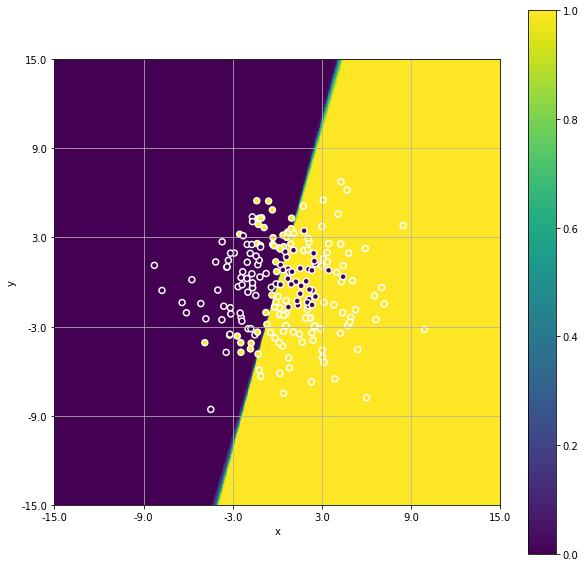

Decision Tree:
Accuracy of base model on train: 0.9037375
Accuracy of base model on test: 0.90255
Accuracy of boosted model on train: 0.91235
Accuracy of boosted model on test: 0.91425


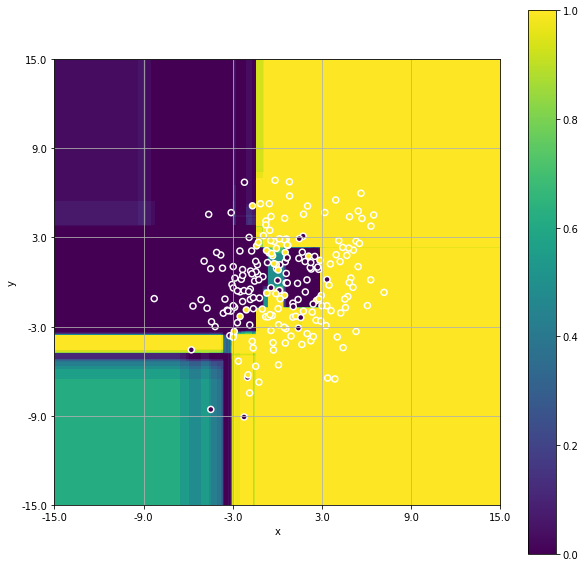

Random Forest (50 trees):
Accuracy of base model on train: 0.999775
Accuracy of base model on test: 0.9102
Accuracy of boosted model on train: 0.94285
Accuracy of boosted model on test: 0.92025


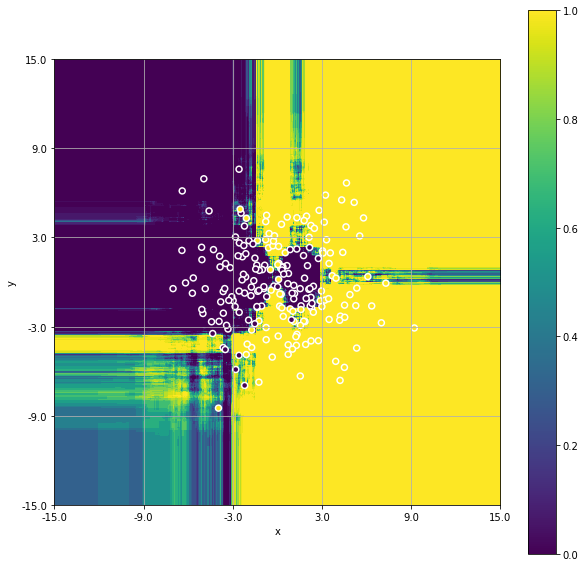

In [108]:
print('Synthetic dataset:')
for i in range(3):
    print(names[i], ':', sep='')
    
    base_model = models[i](**params[i])
    boosted_model = Boosting(base_model_class=models[i], base_model_params=params[i], n_estimators=20)
    
    base_model.fit(X_train_synthetic, y_train_synthetic) 
    print('Accuracy of base model on train:', accuracy_score((y_train_synthetic == 1), np.round(base_model.predict(X_train_synthetic) > 0.5)))
    print('Accuracy of base model on test:', accuracy_score((y_test_synthetic == 1), np.round(base_model.predict(X_test_synthetic) > 0.5)))
    
    boosted_model.fit(X_train_synthetic, y_train_synthetic)
    print('Accuracy of boosted model on train:', accuracy_score((y_train_synthetic == 1), np.round(boosted_model.predict(X_train_synthetic) > 0.5)))
    print('Accuracy of boosted model on test:', accuracy_score((y_test_synthetic == 1), np.round(boosted_model.predict(X_test_synthetic) > 0.5)))
    
    
    plot_predicts(boosted_model, X_test_synthetic, y_test_synthetic)

In [109]:
print('Banking dataset:')
X_train = df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values
y_train = df_train.y.values
X_test = df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values
y_test = df_test.y.values
for i in range(3):
    print(names[i], ':', sep='')
    
    base_model = models[i](**params[i])
    boosted_model = Boosting(base_model_class=models[i], base_model_params=params[i], n_estimators=20)
    
    base_model.fit(X_train, y_train) 
    print('Accuracy of base model on train:', accuracy_score((y_train == 1), np.round(base_model.predict(X_train) > 0.5)))
    print('Accuracy of base model on test:', accuracy_score((y_test == 1), np.round(base_model.predict(X_test) > 0.5)))
    
    boosted_model.fit(X_train, y_train)
    print('Accuracy of boosted model on train:', accuracy_score((y_train == 1), np.round(boosted_model.predict(X_train) > 0.5)))
    print('Accuracy of boosted model on test:', accuracy_score((y_test == 1), np.round(boosted_model.predict(X_test) > 0.5)))

Banking dataset:
Logistic Regression:
Accuracy of base model on train: 0.8521012931034483
Accuracy of base model on test: 0.8464439655172413
Accuracy of boosted model on train: 0.8539870689655172
Accuracy of boosted model on test: 0.8491379310344828
Decision Tree:
Accuracy of base model on train: 0.8911637931034483
Accuracy of base model on test: 0.8830818965517241
Accuracy of boosted model on train: 0.8902209051724138
Accuracy of boosted model on test: 0.8895474137931034
Random Forest (50 trees):
Accuracy of base model on train: 0.9998653017241379
Accuracy of base model on test: 0.8933189655172413
Accuracy of boosted model on train: 0.9127155172413793
Accuracy of boosted model on test: 0.8960129310344828


#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

Cлучайный лес, т.к. он является прямым улучшением всех других моделей.

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

Явно франкенштейновая, но она не работает. Из наших же - бэггинг с семплированием признаков.

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

Ответил бы, если бы эта гениальная модель работала.

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

Случайный лес.

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

Скорее бэггинг, т.к. он лучше избавляет нас от переобучения, в то время как бустинг лучше исправляет смещение.

Комментарий - я промучался чуть больше двух часов, пытаясь найти решение для нерабочего get_params() у франкенштейновой модели, т.к. простое унаследование от BaseEstimator не работало - но везде что-то шло не так - пытаясь копировать параметры, среди которых - модель, параметры которой надо копировать, и т.д. - бэггинг ломается. Если бы модели передавались в наш бустинг нормально, а не как классы и параметры отдельно, это можно было бы пофиксить, но в том состоянии, в котором нам дали исходный класс, решение ускользает от меня. Возможно, можно было бы реализовать свой собственный бэггинг под это задание, но, если честно, на этой неделе на подобное попросту не хватает времени.

In [110]:
from sklearn.ensemble import BaggingClassifier

m = [RandomForestClassifier(n_estimators=20),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1)),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=1), max_features=0.6),
#   BaggingClassifier(base_estimator=Boosting(n_estimators=150)),
    BaggingClassifier(LogisticRegression(max_iter=10000))]

params = [{'max_iter': 10000}, 
          {'max_depth': 6}, 
          {'n_estimators': 100}
]


names = ['Random Forest',
         'Trees Bagging',
         'Trees Bagging (max_features=0.6)',
#        'Trees Boosting Bagging Frankenstein',
         'LR Bagging'
]

In [111]:
print('Synthetic dataset:')
for i, model in enumerate(m):
    print(names[i], ':', sep='')
    
    model.fit(X_train_synthetic, y_train_synthetic)
    print('Accuracy of model on train:', accuracy_score((y_train_synthetic == 1), np.round(model.predict(X_train_synthetic) > 0.5)))
    print('Accuracy of model on test:', accuracy_score((y_test_synthetic == 1), np.round(model.predict(X_test_synthetic) > 0.5)))

Synthetic dataset:
Random Forest:
Accuracy of model on train: 0.9976375
Accuracy of model on test: 0.9101
Trees Bagging:
Accuracy of model on train: 0.9925125
Accuracy of model on test: 0.90485
Trees Bagging (max_features=0.6):
Accuracy of model on train: 0.9893375
Accuracy of model on test: 0.72555
LR Bagging:
Accuracy of model on train: 0.6925
Accuracy of model on test: 0.68915


In [112]:
print('Banking dataset:')
for i, model in enumerate(m):
    print(names[i], ':', sep='')
    
    model.fit(X_train, y_train)
    print('Accuracy of model on train:', accuracy_score((y_train == 1), np.round(model.predict(X_train) > 0.5)))
    print('Accuracy of model on test:', accuracy_score((y_test == 1), np.round(model.predict(X_test) > 0.5)))

Banking dataset:
Random Forest:
Accuracy of model on train: 0.997979525862069
Accuracy of model on test: 0.8890086206896551
Trees Bagging:
Accuracy of model on train: 0.9932650862068966
Accuracy of model on test: 0.8884698275862069
Trees Bagging (max_features=0.6):
Accuracy of model on train: 0.9819504310344828
Accuracy of model on test: 0.875
LR Bagging:
Accuracy of model on train: 0.8542564655172413
Accuracy of model on test: 0.8491379310344828


#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных?

__Бонус (1 балл)__: современное развитие методов машинного обучения позволяет автоматизировать и оптимизировать подбор гиперпараметров. Воспользуйтесь для данной задачи одним из фреймворков для такого подбора - например, [hyperopt](https://github.com/hyperopt/hyperopt) или [optuna](https://github.com/optuna/optuna). Сравните также полученные данным методом модели с простым перебором гиперпараметров. 

In [113]:
import xgboost as xgb
n_estimators_params = np.arange(5, 51, 5)
learning_rate_params = np.logspace(-5, 0, 10)
max_depth_params = np.arange(1, 5, 1)

xgb_optimal_params = [-1, -1, -1]
cbc_optimal_params = [-1, -1, -1]

xgb_optimal_accuracy = 0
cbc_optimal_accuracy = 0

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

for n_estimators in n_estimators_params:
    for learning_rate in learning_rate_params:
        for max_depth in max_depth_params:
            xgc = xgb.XGBClassifier(n_estimators=n_estimators,
                                   learning_rate=learning_rate,
                                   max_depth=max_depth,
                                   use_label_encoder=False)
            xgc.fit(X_train, (y_train + 1) // 2, eval_metric='logloss')
            accuracy = accuracy_score((y_val == 1), np.round(xgc.predict(X_val) > 0.5))
            if accuracy > xgb_optimal_accuracy:
                xgb_optimal_params = [n_estimators, learning_rate, max_depth]
                xgb_optimal_accuracy = accuracy
                print('new xgb optimal accuracy:', xgb_optimal_accuracy)
                print('optimal xgb params:', *xgb_optimal_params)
            
            
            cbc = Boosting(n_estimators=n_estimators,
                                   learning_rate=learning_rate,
                                   base_model_params={'max_features' : 0.1,
                                                     'max_depth' : max_depth})
            cbc.fit(X_train, y_train)
            
            accuracy = accuracy_score((y_val == 1), np.round(cbc.predict(X_val) > 0.5))
            if accuracy > cbc_optimal_accuracy:
                cbc_optimal_params = [n_estimators, learning_rate, max_depth]
                cbc_optimal_accuracy = accuracy
                print('new cbc optimal accuracy:', cbc_optimal_accuracy)
                print('optimal cbc params:', *cbc_optimal_params)

new xgb optimal accuracy: 0.71875
optimal xgb params: 5 1e-05 1
new cbc optimal accuracy: 0.4795258620689655
optimal cbc params: 5 1e-05 1
new xgb optimal accuracy: 0.7478448275862069
optimal xgb params: 5 1e-05 2
new xgb optimal accuracy: 0.8415948275862069
optimal xgb params: 5 1e-05 3
new xgb optimal accuracy: 0.8685344827586207
optimal xgb params: 5 1e-05 4
new cbc optimal accuracy: 0.49030172413793105
optimal cbc params: 5 0.005994842503189409 2
new cbc optimal accuracy: 0.6928879310344828
optimal cbc params: 5 0.005994842503189409 3
new xgb optimal accuracy: 0.8793103448275862
optimal xgb params: 5 0.005994842503189409 4
new cbc optimal accuracy: 0.7155172413793104
optimal cbc params: 5 0.005994842503189409 4
new cbc optimal accuracy: 0.8081896551724138
optimal cbc params: 5 0.021544346900318846 2
new cbc optimal accuracy: 0.8318965517241379
optimal cbc params: 5 0.021544346900318846 3
new cbc optimal accuracy: 0.8642241379310345
optimal cbc params: 5 0.021544346900318846 4
new x

In [114]:
xgc = xgb.XGBClassifier(n_estimators=xgb_optimal_params[0] ,
                       learning_rate=xgb_optimal_params[1],
                       max_depth=xgb_optimal_params[2],
                       use_label_encoder=False)
xgc.fit(X_train, (y_train + 1) // 2, eval_metric='logloss')
accuracy = accuracy_score((y_test== 1), np.round(xgc.predict(X_test) > 0.5))
print('xgb accuracy on test:', accuracy)

cbc = Boosting(n_estimators=cbc_optimal_params[0],
               learning_rate=cbc_optimal_params[1],
               base_model_params={'max_features' : 0.1,
                                 'max_depth' : cbc_optimal_params[2]})
cbc.fit(X_train, y_train)

accuracy = accuracy_score((y_test == 1), np.round(cbc.predict(X_test) > 0.5))

print('cbc accuracy on test:', accuracy)

xgb accuracy on test: 0.8879310344827587
cbc accuracy on test: 0.8739224137931034


шок, xgb оказался лучше моего написанного на коленке класса

#### 5. (Бонус, 1 балл) В этом задании мы поговорим об интерпретации моделей.

Наша бустинговая модель способна возвращать вероятности для классов. Давайте попробуем оценить, насколько эти вероятности согласованы с реальностью. Для этого мы используем уже знакомый вам метод калибровочных кривых. Постройте калибровочные кривые для бустинговой модели и для логистической регрессии на обоих датасетах. Хорошо ли откалиброваны вероятности бустинга?

In [115]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

Бустинг также позволяет рассчитать важность признаков в данных. Для этого существует много подходов, но мы обратимся к самому простому. Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить, после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так). Проделайте это, затем нарисуйте столбчатые диаграммы важности признаков для обоих датасетов. На соседних графиках нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Что можно сказать?

In [116]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (на тех же параметрах!). Стало ли лучше?

In [117]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### 6. (Бонус, 0.01 балла) Готовы ли вы в следующем году пойти ассистентом на этот курс и токсить на набор 19 года во флуде? 

Your answer:
Нет, я не готов ждать целый год, поэтому пойду ассистировать МО у ПИ на 3-4 модуль в этом году.